# Linear

In [1]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from pandas_datareader.data import DataReader
import os
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
from xgboost import XGBRegressor
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
df = pd.read_csv(r'..\stocks\AAPL.csv', index_col=['Date'], parse_dates=['Date'])
df = df.dropna()

# Select the proper time period for daily aggreagation
df = df['2019-01-02':'2020-12-05'].resample('D').sum()
adj_close = df['Adj Close']

In [3]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [4]:
# Creating a copy of the initial dataframe to make various transformations 
data = pd.DataFrame(adj_close.copy())
data.columns = ["y"]

# Adding the lag of the target variable from 6 steps back up to 30
for i in range(6, 30):
    data["lag_{}".format(i)] = data.y.shift(i)
    
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-30,118.872368,114.998154,113.680122,0.000000,0.000000,117.164917,118.462982,117.853889,119.211861,120.120506,...,115.796967,116.146439,0.000000,0.000000,118.512909,118.647697,114.580803,110.085289,108.420654,0.000000
2020-12-01,122.536896,115.856873,114.998154,113.680122,0.000000,0.000000,117.164917,118.462982,117.853889,119.211861,...,119.311707,115.796967,116.146439,0.000000,0.000000,118.512909,118.647697,114.580803,110.085289,108.420654
2020-12-02,122.896355,0.000000,115.856873,114.998154,113.680122,0.000000,0.000000,117.164917,118.462982,117.853889,...,119.032127,119.311707,115.796967,116.146439,0.000000,0.000000,118.512909,118.647697,114.580803,110.085289
2020-12-03,122.756569,116.416031,0.000000,115.856873,114.998154,113.680122,0.000000,0.000000,117.164917,118.462982,...,119.082054,119.032127,119.311707,115.796967,116.146439,0.000000,0.000000,118.512909,118.647697,114.580803
2020-12-04,122.067596,0.000000,116.416031,0.000000,115.856873,114.998154,113.680122,0.000000,0.000000,117.164917,...,0.000000,119.082054,119.032127,119.311707,115.796967,116.146439,0.000000,0.000000,118.512909,118.647697


In [5]:
# for time-series cross-validation set 7 folds 
tscv = TimeSeriesSplit(n_splits=7)

In [6]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [7]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 10% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

In [8]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [9]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

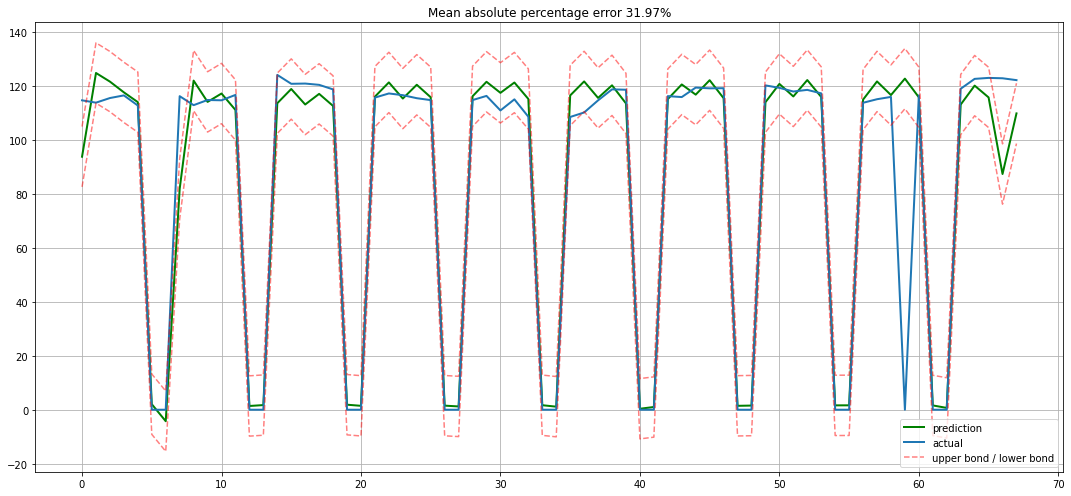

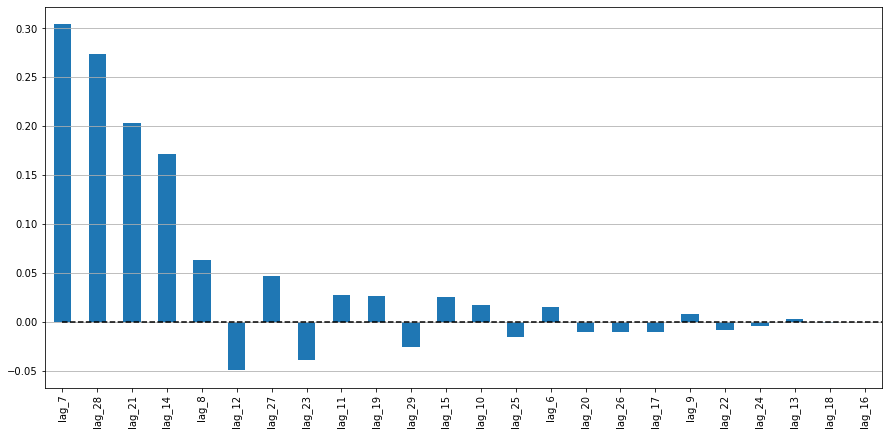

In [10]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [11]:
data.index = pd.to_datetime(data.index)
data["weekday"] = data.index.weekday
# 5 and 6 index = weekends
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,weekday,is_weekend
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-30,118.872368,114.998154,113.680122,0.000000,0.000000,117.164917,118.462982,117.853889,119.211861,120.120506,...,0.000000,0.000000,118.512909,118.647697,114.580803,110.085289,108.420654,0.000000,0,0
2020-12-01,122.536896,115.856873,114.998154,113.680122,0.000000,0.000000,117.164917,118.462982,117.853889,119.211861,...,116.146439,0.000000,0.000000,118.512909,118.647697,114.580803,110.085289,108.420654,1,0
2020-12-02,122.896355,0.000000,115.856873,114.998154,113.680122,0.000000,0.000000,117.164917,118.462982,117.853889,...,115.796967,116.146439,0.000000,0.000000,118.512909,118.647697,114.580803,110.085289,2,0
2020-12-03,122.756569,116.416031,0.000000,115.856873,114.998154,113.680122,0.000000,0.000000,117.164917,118.462982,...,119.311707,115.796967,116.146439,0.000000,0.000000,118.512909,118.647697,114.580803,3,0
2020-12-04,122.067596,0.000000,116.416031,0.000000,115.856873,114.998154,113.680122,0.000000,0.000000,117.164917,...,119.032127,119.311707,115.796967,116.146439,0.000000,0.000000,118.512909,118.647697,4,0


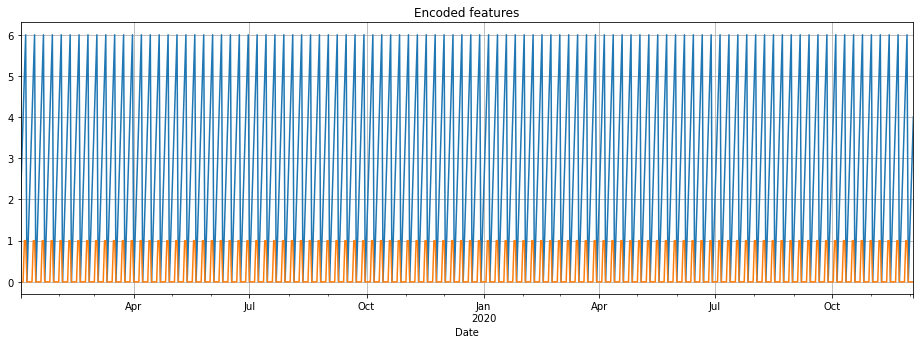

In [12]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True)

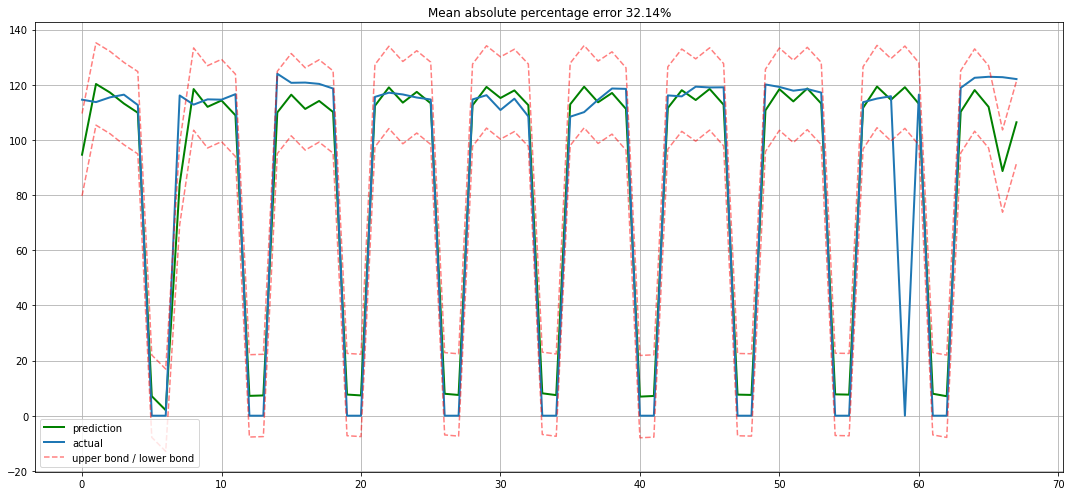

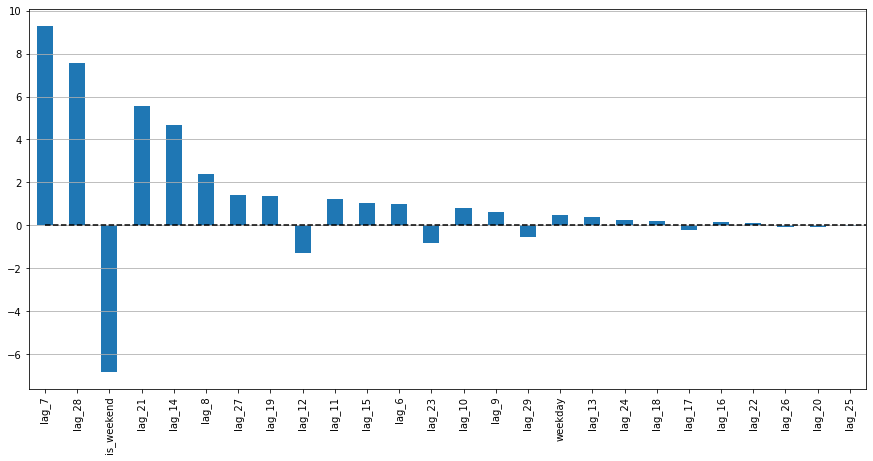

In [13]:
scaler = StandardScaler()
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [14]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

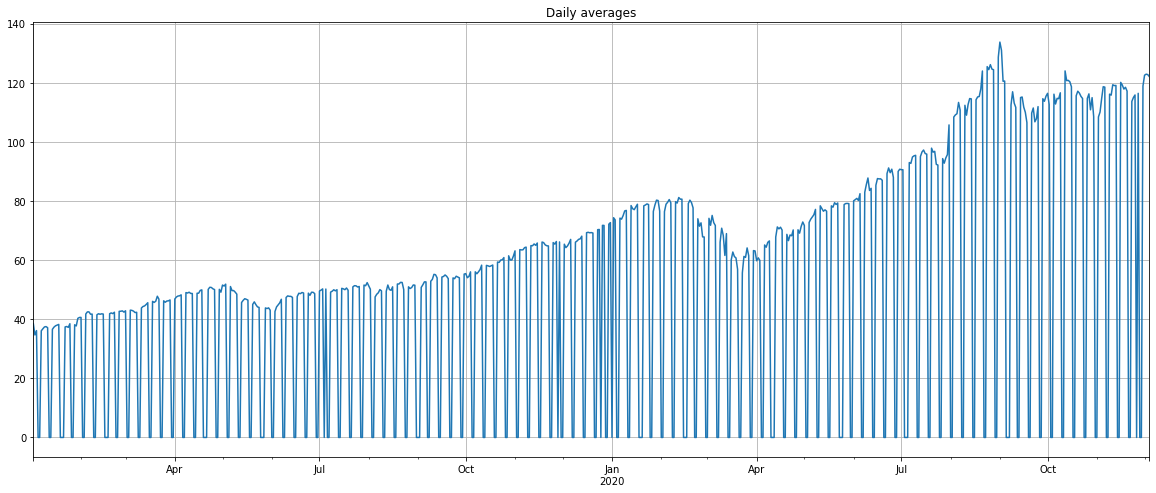

In [15]:
average_date = code_mean(data, 'Date', "y")
plt.figure(figsize=(20, 8))
plt.title("Daily averages")
pd.DataFrame.from_dict(average_date, orient='index')[0].plot()
plt.grid(True);

In [16]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

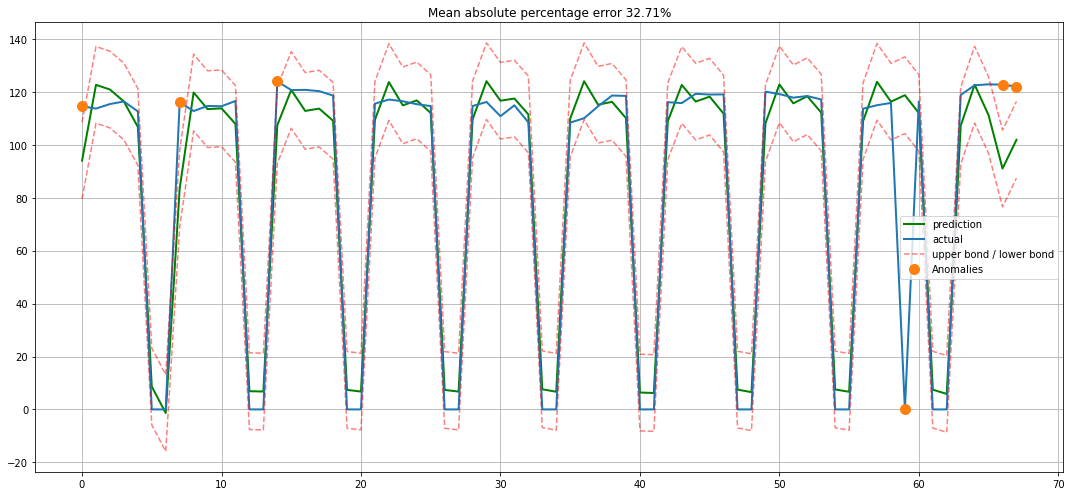

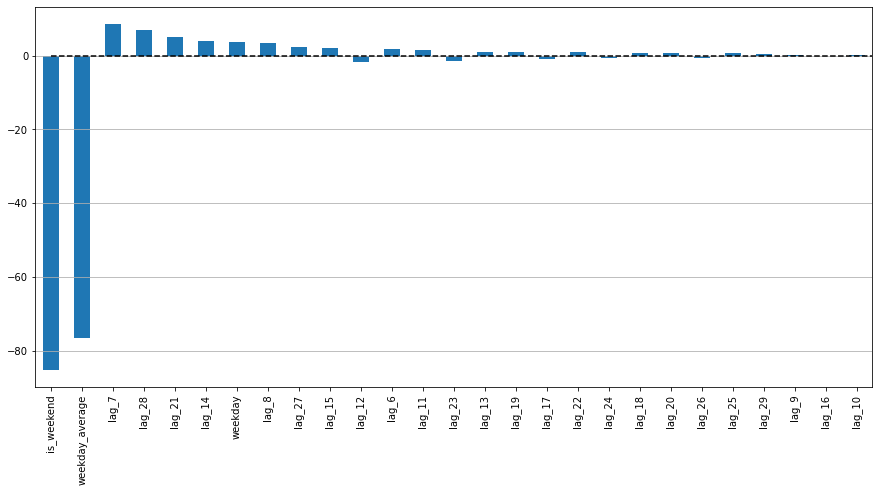

In [17]:
X_train, X_test, y_train, y_test =\
prepareData(adj_close, lag_start=6, lag_end=30, test_size=0.1, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [18]:
X_train, X_test, y_train, y_test =\
prepareData(adj_close, lag_start=6, lag_end=30, test_size=0.1, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

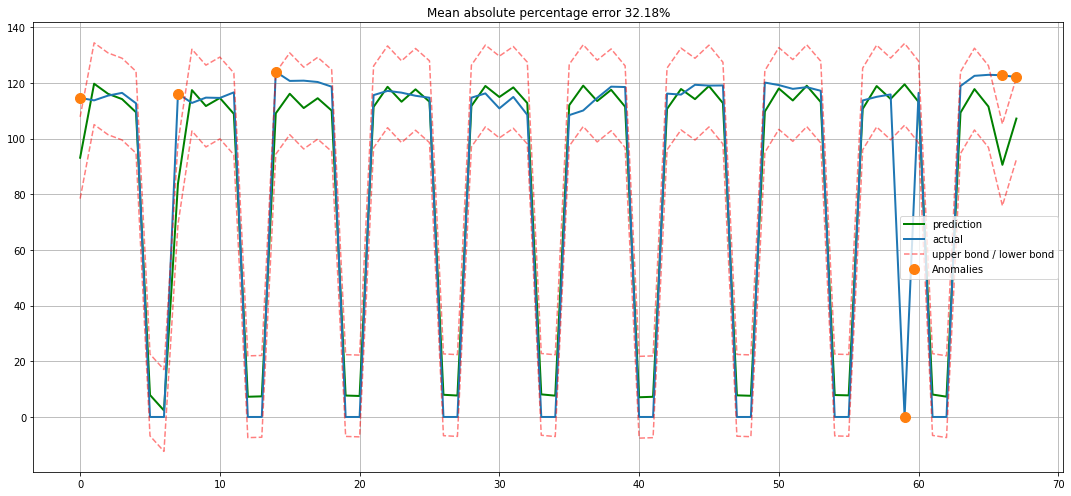

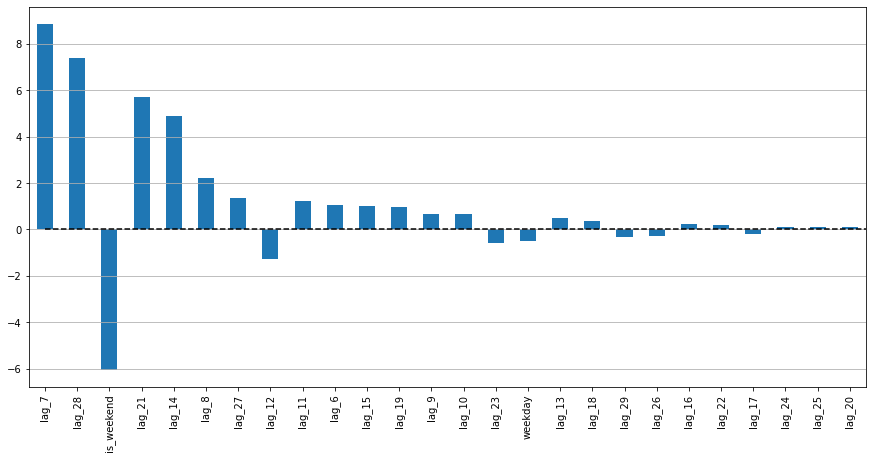

In [19]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

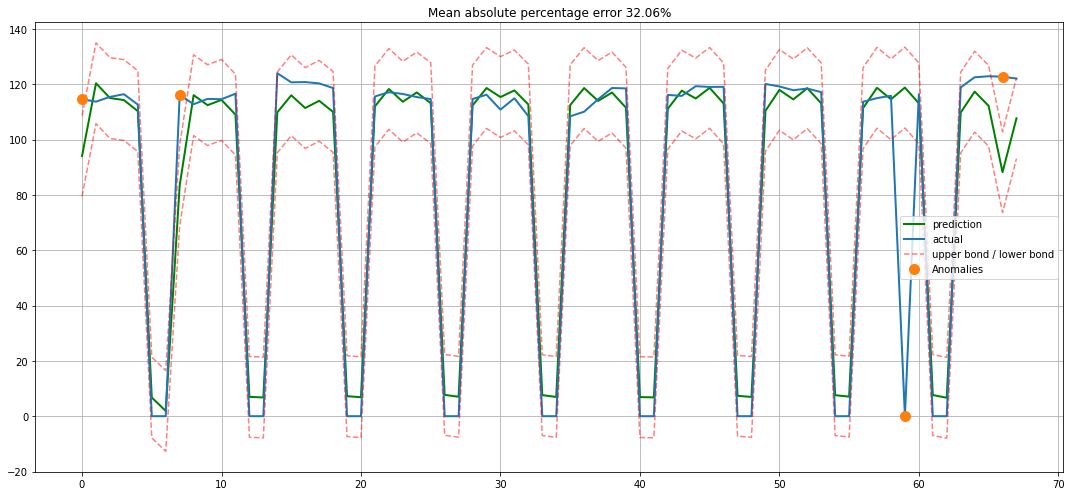

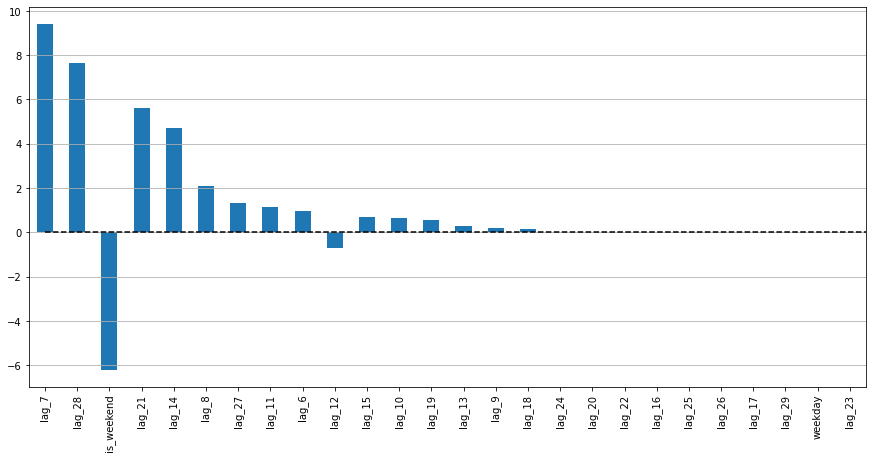

In [20]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

### Boosting

In [21]:
xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

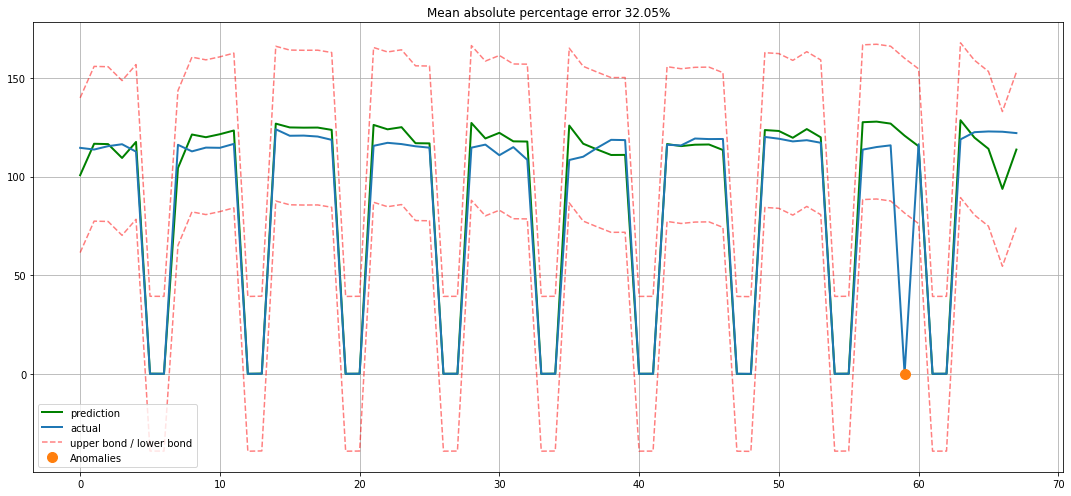

In [22]:
plotModelResults ( xgb ,  
                 X_train = X_train_scaled ,  
                 X_test = X_test_scaled ,  
                 plot_intervals = True ,  plot_anomalies = True )